##  Régression avec un réseau de neurones profonds (DNN)

In [194]:
# chargement des bibliotheques .......

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)


2.6.0


## Collecter et prétraiter les données¶

La première étape consiste à collecter et prétraiter les données appropriées pour garantir qu'elles sont dans un format que le réseau neuronal peut utiliser. Cela peut impliquer le nettoyage des données, la gestion des valeurs manquantes et la normalisation des données. 

In [218]:
# chargement du dataframe avec conversion decimal des virgules par des point...............


dataset = pd.read_csv('household_power_consumption .txt', delimiter=";", decimal=",")
dataset.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [219]:
dataset.shape

(2075259, 9)

In [ ]:
# 1.date 

# 2.time

# 3.global_active_power : puissance active moyenne mondiale des ménages par minute (en kilowatts)

# 4.global_reactive_power : puissance réactive moyenne mondiale des ménages par minute (en kilowatts)

# 5. tension : tension moyenne à la minute (en volts)

# 6.global_intensity : intensité de courant moyenne mondiale par minute dans le ménage (en ampères)

# 7.sub_metering_1 : sous-comptage d'énergie n°1 (en wattheure d'énergie active).  Il correspond à la cuisine, contenant principalement un lave-vaisselle, un four et un micro-ondes (les plaques de cuisson ne sont pas électriques mais au gaz).

# 8.sub_metering_2 : sous-comptage d'énergie n°2 (en wattheure d'énergie active).  Il correspond à la buanderie, contenant un lave-linge, un sèche-linge, un réfrigérateur et un luminaire.

# 9.sub_metering_3 : sous-comptage d'énergie n°3 (en wattheure d'énergie active).  Il correspond à un chauffe-eau électrique et un climatiseur. 

# outils pour le traitement du dataframe


In [196]:
# Passer un DataFrame à get_dummies()


dataset = pd.get_dummies(dataset, columns=['col1', 'col2','col3'])

In [266]:
# Pour voir le type de données de chaque colonne. 

dataset.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [235]:
# pour convertir en float32 toutes les colonnes...........
dataset = dataset.astype('float64')

In [ ]:
# pour convertir certaines colonnes...........
dataset[float64_cols] = dataset[float64_cols].astype('float32')


In [ ]:
# pour transformer toutes les colonnes.........

dataset=dataset.apply(pd.to_numeric)

In [221]:
# suppression des colonnes inutiles............

dataset=dataset.drop(['Date','Time'], axis=1)

In [227]:
# pour visualiser les lignes NaN................

dataset.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [228]:
# pour supprimer les NaN..............

dataset=dataset.dropna()

In [236]:
# pour visualiser les lignes NaN................

dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [237]:
# pour verifier..........

dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Prétraitement des données du dataset

In [238]:
# divisions les données en un ensembles d'entrainement et de test...............

# utilisation de l'ensemble des données de test pour l'évaluation finale.........

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print('Nombre de lignes l entrainement',train_dataset.shape)
print('Nombre de lignes pour les test', test_dataset.shape)

Nombre de lignes l entrainement (1639424, 7)
Nombre de lignes pour les test (409856, 7)


In [239]:
# séparation  les entités des étiquettes...........
# séparation de la valeur cible des caractéristiques ( features )..........
# c'est cette cible que le modele va devoir prédire.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Global_active_power') # la cible est la puissance active moyenne
test_labels = test_features.pop('Global_active_power') # mondiale des ménages par minute

Dans l'analyse de régression utilisant un DNN, l'objectif est d'apprendre une fonction qui mappe les caractéristiques d'entrée à la sortie, de sorte que les prédictions faites par le modèle soient aussi précises que possible. Les caractéristiques d'entrée passent par la couche d'entrée du DNN puis sont traitées par les couches cachées, qui utilisent des fonctions d'activation non linéaires pour apprendre les relations complexes dans les données. La couche de sortie du DNN produit une prédiction pour la variable dépendante basée sur les caractéristiques d'entrée traitées

## Définir l'architecture du mdele

L'étape suivante consiste à définir l'architecture du réseau de neurones. Cela inclut la sélection du type de couches (couches denses ou convolutives), du nombre de neurones dans chaque couche et des fonctions d'activation à utiliser.


## Compiler le modele

Une fois l'architecture définie, il faut compiler le modèle. Cela implique de spécifier la fonction de perte, l'optimiseur et toutes les métriques que nous utiliserons pour évaluer le modèle.


In [240]:
# normalisation les données avec (tf.keras.layers.Normalization)...........


normalizer = tf.keras.layers.Normalization(axis=-1)

In [241]:
# modèles DNN à entrées multiples....................

normalizer.adapt(np.array(train_features))

In [242]:
#  Régression avec un réseau de neurones profond (DNN)..........
# modèles DNN à entrées multiples.


def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),# 2 couches Dense avec fonction activation relu
      layers.Dense(64, activation='relu'),
      layers.Dense(1) # une couche Dense linéaire à sortie unique
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    
  # model.compile(optimizer='adam',
  #              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #              metrics=['accuracy'])
  # model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
  #  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   #           metrics=["accuracy"])

  return model


In [243]:
# Régression utilisant un DNN et plusieurs entrées

# Répétez le processus précédent en utilisant toutes les entrées.
# Les performances du modèle s'améliorent légèrement sur l'ensemble de données de validation.

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_14 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_39 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [260]:
# la fonction d affichage....

def plot_loss(history):
  plt.plot(history.history['loss'], label='MAE')
  plt.plot(history.history['val_loss'], label='val_MAE')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Erreur en $ [Global_active_power]')
  plt.legend()
  plt.grid(True)

## Entrainer le modele

L'étape suivante consiste à entraîner le modèle à l'aide des données prétraitées. Cela implique d'introduire les données dans le modèle et d'ajuster les poids et les biais des neurones du réseau pour minimiser la fonction de perte.


In [254]:
# entrainement ....................

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=2)



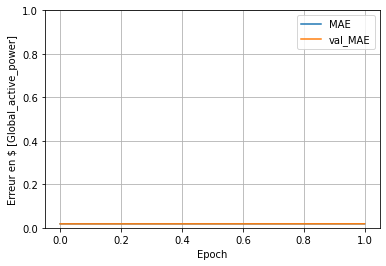

In [261]:
plot_loss(history)

## Evaluer le modele

Une fois le modèle entraîné, il doit être évalué pour déterminer ses performances. Cela peut impliquer l'utilisation d'un ensemble de données distinct (ou d'un sous-ensemble des données d'entraînement) pour évaluer la capacité du modèle à effectuer des prédictions précises.


In [262]:
# résultats de la MAE sur l'ensemble de test :

test_resultats = {}

test_resultats['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_resultats

{'dnn_model': 0.01842750608921051}

## Faire des prédiction

Une fois le modèle affiné, nous pouvons l'utiliser pour prédire de nouvelles données.


In [265]:
#  prédiction...

y_pred = dnn_model.predict(test_features)
print('prédiction de Global_active_power ',y_pred[1:5])
print('Global_active_power  attendue',test_labels[1:5])

prédiction de Global_active_power  [[3.697]
 [5.407]
 [3.287]
 [3.234]]
Global_active_power  attendue 4     3.666
11    5.412
16    3.270
26    3.236
Name: Global_active_power, dtype: float64


In [29]:
pd.DataFrame(test_resultats, index=['Mean absolute error [T]']).T


,Mean absolute error [T]
dnn_model,1.108887


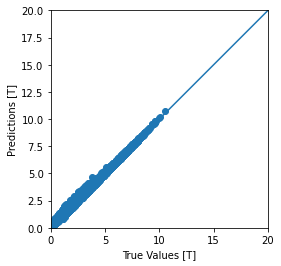

In [269]:
# Faire des prédictions
# Vous pouvez maintenant faire des prédictions avec le dnn_model
# sur l'ensemble de test à l'aide de ( Keras Model.predict) et examiner la perte :

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Global_active_power]')
plt.ylabel('Predictions [Global_active_power]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


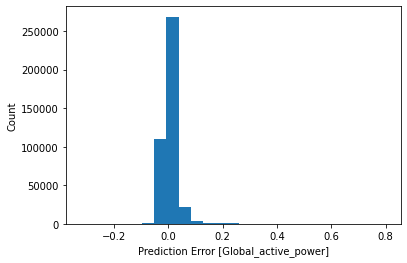

In [270]:
# vérifiez la distribution des erreurs :

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Global_active_power]')
_ = plt.ylabel('Count')


In [ ]:
#  enregistrez-le pour une utilisation ultérieure avec Model.save :

dnn_model.save('dnn_model')


2023-11-29 23:05:12.705326: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [41]:
#  rechargez le modèle, il donne une sortie identique :

reloaded = tf.keras.models.load_model('dnn_model')

test_resultats['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)


In [43]:
pd.DataFrame(test_resultats, index=['Mean absolute error [T]']).T


,Mean absolute error [T]
dnn_model,1.108887
reloaded,1.108887


## merci Tensorflow........